In [1]:
import numpy as np  # NumPy for arrays
import torch  # PyTorch for tensors
import torch.nn as nn  # Neural network module
from torch.utils.data import DataLoader, TensorDataset  # Data loading utilities
import torch.optim as optim
import matplotlib.pyplot as plt  # For plotting
from matplotlib import cm  # Colormap for plots
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn.init as init

# Data Generating Process

In [2]:
def dgp_y(x):
    torch.manual_seed(123)
    y = 2*(1-torch.exp(-torch.abs(x+torch.sin(x**2))))
    return y

In [3]:
x_train = torch.arange(0,6,0.5).unsqueeze(dim=1)
y_train = dgp_y(x_train)
x_test = torch.arange(0,6,0.01).unsqueeze(dim=1)
y_test = dgp_y(x_test)

## Saving the data for plotting later

In [4]:
training_data_df = pd.DataFrame({'X_train': x_train.numpy().flatten() , 'Y_train': y_train.numpy().flatten()})

results_df = pd.DataFrame({'X_test': x_test.numpy().flatten()})



In [5]:
pre_train_df =  pd.DataFrame({'X_test': x_test.numpy().flatten()})


In [6]:
#plt.scatter(x_train,y_train, color = "r")
#plt.plot(x_test,y_test)
#plt.title("Data Generating Process")
#plt.xlabel("x")
#plt.ylabel("y")
#plt.show()

# Training procedure

## Setting up the neural network

In [7]:
class NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128):
        super().__init__()
        self.dim_hidden= dim_hidden
        
        self.y = nn.Sequential(
            nn.Linear(1, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, 1),
        )

    def forward(self, x):
        return self.y(x)

In [8]:
class NN(nn.Module):
    def __init__(self, dim_hidden=128):
        super().__init__()
        self.dim_hidden = dim_hidden

        self.y = nn.Sequential(
            nn.Linear(1, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, 1),
        )
        
        # Initialize the first layer weights and biases
        self._init_first_layer()

    def _init_first_layer(self):
        # Access the first layer (Linear layer) and initialize
        init.uniform_(self.y[0].weight, a=-0.25, b=0.25)  # Specify range as needed
        init.uniform_(self.y[0].bias, a=-0.25, b=0.25)    # Specify range as needed
        init.uniform_(self.y[2].weight, a=-0.25, b=0.25)  # Specify range as needed
        init.uniform_(self.y[2].bias, a=-0.25, b=0.25)    # Specify range as needed
        init.uniform_(self.y[4].weight, a=-0.25, b=0.25)  # Specify range as needed
        init.uniform_(self.y[4].bias, a=-0.25, b=0.25)    # Specify range as needed
        init.uniform_(self.y[6].weight, a=-0.25, b=0.25)  # Specify range as needed
        init.uniform_(self.y[6].bias, a=-0.25, b=0.25)    # Specify range as needed


    def forward(self, x):
        return self.y(x)

# Example instantiation

## setting up the data loader (outside of the training loop)

In [9]:
batch_size = x_train.shape[0] # We are going full batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle= False)

## Setting up the optimizer 
You might ask why I switched from `LBFGS` to `Adam`. The previous exercise, found in `smooth_interpolation`, focused on finding the interpolation threshold, a task where `LBFGS` excels. However, here we want to illustrate a point about the standard practices in deep learning. In practice, most of the community uses `Adam`.

In [10]:
criterion = nn.MSELoss()

def training():
    model = NN()
    y_pre = model(x_test).detach()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
    num_epochs = 10000
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()  
        if (epoch+1) % 5000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}')
    return y_pre, model(x_test).detach() #returns the pretraining function and after train function 

### Testing

In [11]:
y_pre, y_hat = training()

Epoch [5000/10000], Loss: 0.00001
Epoch [10000/10000], Loss: 0.00000


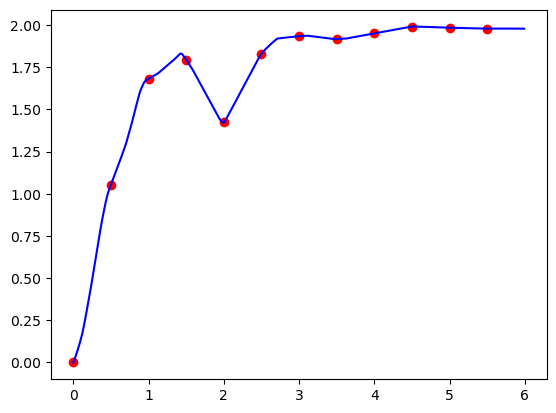

In [12]:
plt.scatter(x_train,y_train, color = "r", label = "Training Data")
plt.plot(x_test,y_hat, color = "b", label = "Median")

In [13]:
new_rows = []
new_rows_pre = []
num_experiments = 100
for i in range(num_experiments):
    print(i)
    y_pre, y_hat = training()
    y_pre = y_pre.numpy().flatten()
    y_hat = y_hat.numpy().flatten()
    
    column_name = f'y_hat_{i}'
    new_rows = pd.DataFrame({column_name: y_hat})
    results_df = pd.concat([results_df, new_rows], axis=1)

    column_name_pre = f'y_pre_{i}'
    new_rows_pre = pd.DataFrame({column_name_pre: y_pre})
    pre_train_df = pd.concat([pre_train_df, new_rows_pre], axis=1)

0
Epoch [5000/10000], Loss: 0.00001
Epoch [10000/10000], Loss: 0.00000
1
Epoch [5000/10000], Loss: 0.00001
Epoch [10000/10000], Loss: 0.00000
2
Epoch [5000/10000], Loss: 0.00000
Epoch [10000/10000], Loss: 0.00000
3
Epoch [5000/10000], Loss: 0.00195
Epoch [10000/10000], Loss: 0.00000
4
Epoch [5000/10000], Loss: 0.00000
Epoch [10000/10000], Loss: 0.00000
5
Epoch [5000/10000], Loss: 0.00000
Epoch [10000/10000], Loss: 0.00000
6
Epoch [5000/10000], Loss: 0.00001
Epoch [10000/10000], Loss: 0.00000
7
Epoch [5000/10000], Loss: 0.00000
Epoch [10000/10000], Loss: 0.00000
8
Epoch [5000/10000], Loss: 0.00000
Epoch [10000/10000], Loss: 0.00000
9
Epoch [5000/10000], Loss: 0.00000
Epoch [10000/10000], Loss: 0.00000
10
Epoch [5000/10000], Loss: 0.00005
Epoch [10000/10000], Loss: 0.00000
11
Epoch [5000/10000], Loss: 0.00000
Epoch [10000/10000], Loss: 0.00000
12
Epoch [5000/10000], Loss: 0.00000
Epoch [10000/10000], Loss: 0.00000
13
Epoch [5000/10000], Loss: 0.00023
Epoch [10000/10000], Loss: 0.00003
14

In [14]:
results_df.to_csv("./files/smooth_interpolation_100_seeds_different_dist_init.csv", index=False)

In [15]:
training_data_df.to_csv("./files/smooth_interpolation_train_data_different_dist_init.csv", index=False)

In [16]:
pre_train_df.to_csv("./files/smooth_interpolation_pre_train_different_dist_init.csv", index=False)

# counting the number of parameters

In [17]:
def count_parameters(model):
    """
    Counts the number of trainable weights and biases in the neural network.

    Parameters:
    - model: The PyTorch model

    Returns:
    - total_params: The total number of parameters (weights + biases)
    """
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()  # numel() returns the total number of elements (weights/biases) in the parameter
    return total_params

model = NN()

count_parameters(model)

33409